In [6]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [7]:
# Some functions to help out with
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [2]:
import os
fileList = os.listdir("/content/sample_data")

In [3]:
companyList = []
for file in fileList:
    companyName = file.split("_")[0]
    if companyName != "all":
        companyList.append(companyName)
print(companyList)

['README.md', 'anscombe.json', 'mnist', 'california', 'california', 'mnist']


In [8]:
# First, we get the data
stockList = ["AABA", "AAPL"]
df_ = {}
for i in stockList:
    df_[i] = pd.read_csv("/content/sample_data/" + i + "_2006-01-01_to_2018-01-01.csv", index_col="Date", parse_dates=["Date"])

In [9]:
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_new = {}
for i in stockList:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split(df_[i], "2015", "Close")

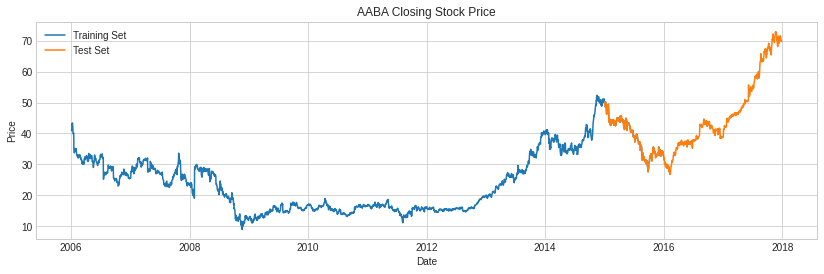

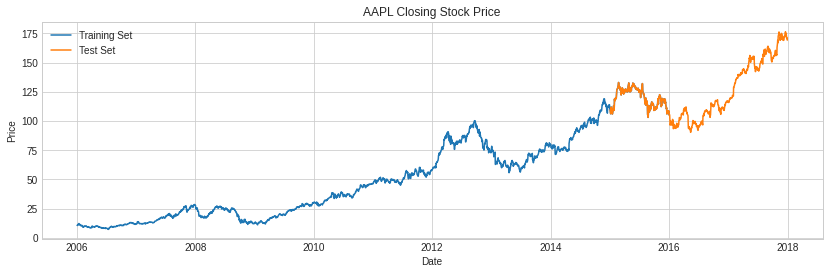

In [10]:
for i in stockList:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing Stock Price")

In [11]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(stockList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [12]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

AABA (2516, 1)
AAPL (2516, 1)


AABA (755, 1)
AAPL (755, 1)


In [13]:
trainset = {}
testset = {}
for j in stockList:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(60,2516):
        X_train.append(transform_train[j][i-60:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(60, 755):
        X_test.append(transform_test[j][i-60:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [14]:
arr_buff = []
for i in stockList:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockList)

,X_train,y_train,X_test,y_test
AABA,"(2456, 60, 1)","(2456,)","(695, 60, 1)","(695,)"
AAPL,"(2456, 60, 1)","(2456,)","(695, 60, 1)","(695,)"


In [15]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in stockList:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=200)

Fitting to AABA
Epoch 1/10
13/13 [==============================] - 12s 305ms/step - loss: 0.0573
Epoch 2/10
13/13 [==============================] - 4s 303ms/step - loss: 0.0150
Epoch 3/10
13/13 [==============================] - 4s 301ms/step - loss: 0.0158
Epoch 4/10
13/13 [==============================] - 4s 300ms/step - loss: 0.0122
Epoch 5/10
13/13 [==============================] - 4s 298ms/step - loss: 0.0136
Epoch 6/10
13/13 [==============================] - 4s 300ms/step - loss: 0.0112
Epoch 7/10
13/13 [==============================] - 4s 298ms/step - loss: 0.0124
Epoch 8/10
13/13 [==============================] - 4s 295ms/step - loss: 0.0104
Epoch 9/10
13/13 [==============================] - 4s 297ms/step - loss: 0.0091
Epoch 10/10
13/13 [==============================] - 4s 297ms/step - loss: 0.0103
Fitting to AAPL
Epoch 1/10
13/13 [==============================] - 4s 298ms/step - loss: 0.0099
Epoch 2/10
13/13 [==============================] - 4s 296ms/step - loss: 0

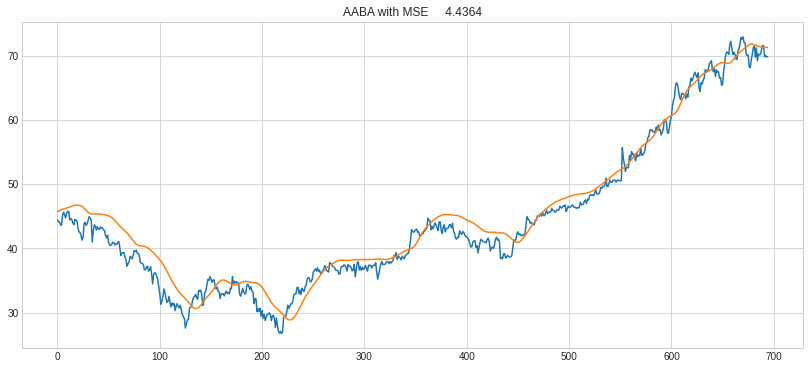

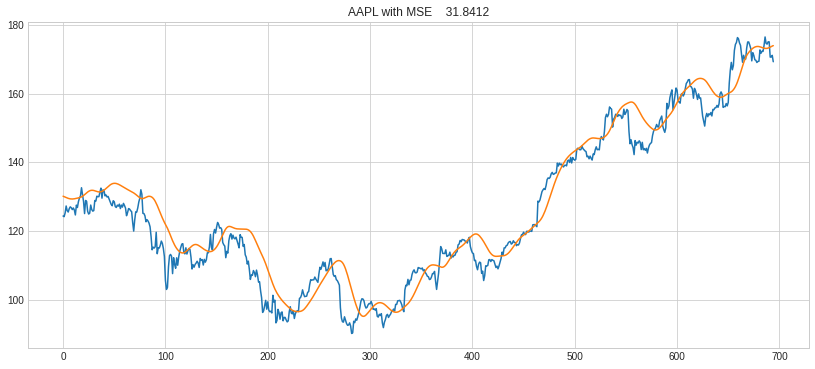

In [16]:
pred_result = {}
for i in stockList:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)

In [17]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
for i in stockList:
    print("Fitting to", i)
    regressorGRU.fit(trainset[i]["X"], trainset[i]["y"],epochs=50,batch_size=150)

Fitting to AABA
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


17/17 [==============================] - 11s 227ms/step - loss: 0.0795
Epoch 2/50
17/17 [==============================] - 4s 232ms/step - loss: 0.0232
Epoch 3/50
17/17 [==============================] - 4s 232ms/step - loss: 0.0058
Epoch 4/50
17/17 [==============================] - 4s 230ms/step - loss: 0.0037
Epoch 5/50
17/17 [==============================] - 4s 229ms/step - loss: 0.0030
Epoch 6/50
17/17 [==============================] - 4s 229ms/step - loss: 0.0027
Epoch 7/50
17/17 [==============================] - 4s 229ms/step - loss: 0.0028
Epoch 8/50
17/17 [==============================] - 4s 228ms/step - loss: 0.0026
Epoch 9/50
17/17 [==============================] - 4s 230ms/step - loss: 0.0024
Epoch 10/50
17/17 [==============================] - 4s 228ms/step - loss: 0.0025
Epoch 11/50
17/17 [==============================] - 4s 227ms/step - loss: 0.0022
Epoch 12/50
17/17 [==============================] - 4s 232ms/step - loss: 0.0023
Epoch 13/50
17/17 [================

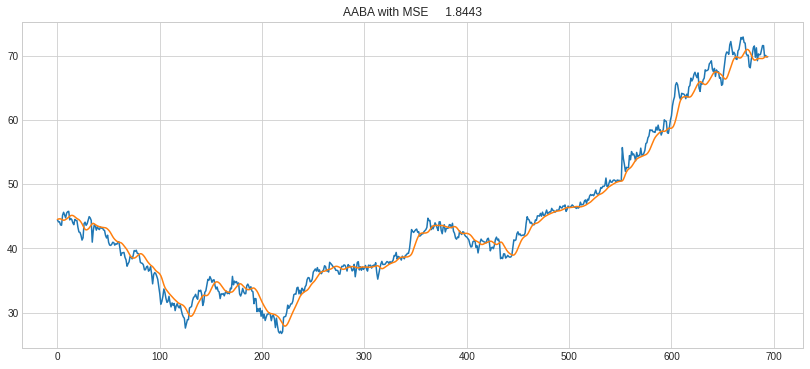

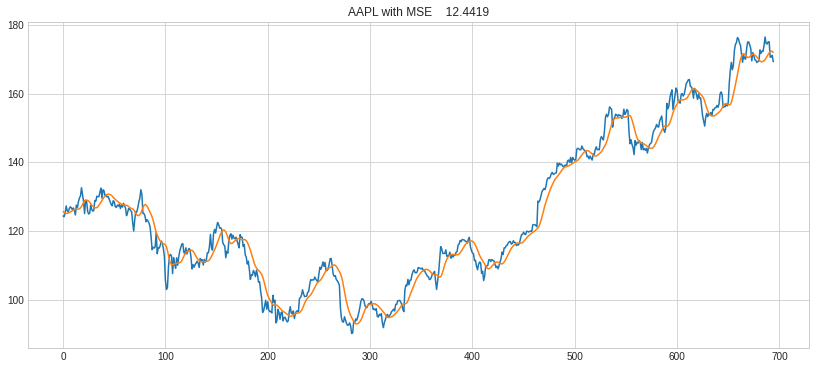

In [18]:
for i in stockList:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressorGRU.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)